[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fadheladlansyah/Fashion_Segmentation/blob/master/eda.ipynb)

reference : https://www.kaggle.com/pednoi/training-mask-r-cnn-to-be-a-fashionista-lb-0-07

## Kaggle access

In [0]:
# use upload buttton or 
# use below code to upload files
from google.colab import files

# # install Kaggle library
# !pip list
# !pip install -q kaggle

# # upload kaggle API key file
# uploaded = files.upload()

In [0]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

## Download and Config

In [2]:
# download dataset
!kaggle competitions download -c imaterialist-fashion-2019-fgvc6 -p ./data -q

*   iMaterialist 2020: belum bisa diakses. Akses sesudah kompetisi berakhir tanggal 28 Mei 2020.
*   iMaterialist 2019: tidak bisa download semua image data. belum tahu caranya.
*   iMaterialist 2018: not applicable. kasus deteksi



In [0]:
import os

ROOT_DIR = os.getcwd()
DATA_DIR = os.path.join(os.getcwd(), 'data')

In [0]:
# os.listdir(DATA_DIR)  # not all image data available

In [5]:
!git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')

!rm -rf .git # to prevent an error when the kernel is committed
!rm -rf images assets # to prevent displaying images at the bottom of a kernel

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 116.75 MiB | 13.00 MiB/s, done.
Resolving deltas: 100% (567/567), done.


In [6]:
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Using TensorFlow backend.


In [7]:
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = 'mask_rcnn_coco.h5'

-rw-r--r-- 1 root root 246M Nov 26  2017 mask_rcnn_coco.h5


In [0]:
# For demonstration purpose, the classification ignores attributes (only categories),
# and the image size is set to 512, which is the same as the size of submission masks
NUM_CATS = 46
IMAGE_SIZE = 512

In [9]:
class FashionConfig(Config):

    NAME = "fashion"
    NUM_CLASSES = NUM_CATS + 1 # +1 for the background class
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4 # a memory error occurs when IMAGES_PER_GPU is too high
    
    BACKBONE = 'resnet50'
    
    IMAGE_MIN_DIM = IMAGE_SIZE
    IMAGE_MAX_DIM = IMAGE_SIZE    
    IMAGE_RESIZE_MODE = 'none'
    
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    #DETECTION_NMS_THRESHOLD = 0.0
    
    # STEPS_PER_EPOCH should be the number of instances 
    # divided by (GPU_COUNT*IMAGES_PER_GPU), and so should VALIDATION_STEPS;
    # however, due to the time limit, I set them so that this kernel can be run in 9 hours
    STEPS_PER_EPOCH = 1000
    VALIDATION_STEPS = 200
    
config = FashionConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                59
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

## ARRANGE DATASET

In [0]:
import numpy as np
import pandas as pd
import random

import cv2

import json

In [0]:
with open(os.path.join(DATA_DIR,'label_descriptions.json')) as f:
    label_descriptions = json.load(f)

label_names = [x['name'] for x in label_descriptions['categories']]

In [18]:
segment_df = pd.read_csv(os.path.join(DATA_DIR,'train.csv.zip'))

multilabel_percent = len(segment_df[segment_df['ClassId'].str.contains('_')])/len(segment_df)*100
print(f"Segments that have attributes: {multilabel_percent:.2f}%")

Segments that have attributes: 3.47%


In [19]:
segment_df['CategoryId'] = segment_df['ClassId'].str.split('_').str[0]

print("Total segments: ", len(segment_df))
segment_df.head()

Total segments:  331213


,ImageId,EncodedPixels,Height,Width,ClassId,CategoryId
0,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6,6
1,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0,0
2,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28,28
3,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31,31
4,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32,32


In [20]:
image_df = segment_df.groupby('ImageId')['EncodedPixels', 'CategoryId'].agg(lambda x: list(x))
size_df = segment_df.groupby('ImageId')['Height', 'Width'].mean()
image_df = image_df.join(size_df, on='ImageId')

print("Total images: ", len(image_df))
image_df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


Total images:  45195


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,EncodedPixels,CategoryId,Height,Width
ImageId,,,,
00000663ed1ff0c4e0132b9b9ac53f6e.jpg,[6068157 7 6073371 20 6078584 34 6083797 48 60...,"[6, 0, 28, 31, 32, 32, 31, 29, 4]",5214,3676
0000fe7c9191fba733c8a69cfaf962b7.jpg,[2201176 1 2203623 3 2206071 5 2208518 8 22109...,"[33, 1]",2448,2448
0002ec21ddb8477e98b2cbb87ea2e269.jpg,[2673735 2 2676734 8 2679734 13 2682733 19 268...,"[33, 10, 23, 23]",3000,1997
0002f5a0ebc162ecfb73e2c91e3b8f62.jpg,[435 132 1002 132 1569 132 2136 132 2703 132 3...,"[10, 33, 15]",567,400
0004467156e47b0eb6de4aa6479cbd15.jpg,[132663 8 133396 25 134130 41 134868 53 135611...,"[10, 33, 31, 31, 15]",750,500


In [50]:
available_images = [f for f in os.listdir(DATA_DIR) if f[-3:]=='jpg']
image_df_try = pd.DataFrame()
for image in list(image_df.index):
  if image in available_images:
    image_df_try = image_df_try.append(image_df.loc[image])

image_df_try.head()

,CategoryId,EncodedPixels,Height,Width
00000663ed1ff0c4e0132b9b9ac53f6e.jpg,"[6, 0, 28, 31, 32, 32, 31, 29, 4]",[6068157 7 6073371 20 6078584 34 6083797 48 60...,5214.0,3676.0
0000fe7c9191fba733c8a69cfaf962b7.jpg,"[33, 1]",[2201176 1 2203623 3 2206071 5 2208518 8 22109...,2448.0,2448.0
0002ec21ddb8477e98b2cbb87ea2e269.jpg,"[33, 10, 23, 23]",[2673735 2 2676734 8 2679734 13 2682733 19 268...,3000.0,1997.0
0002f5a0ebc162ecfb73e2c91e3b8f62.jpg,"[10, 33, 15]",[435 132 1002 132 1569 132 2136 132 2703 132 3...,567.0,400.0
0004467156e47b0eb6de4aa6479cbd15.jpg,"[10, 33, 31, 31, 15]",[132663 8 133396 25 134130 41 134868 53 135611...,750.0,500.0


In [0]:
def resize_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)  
    return img

In [0]:
class FashionDataset(utils.Dataset):

    def __init__(self, df):
        super().__init__(self)
        
        # Add classes
        for i, name in enumerate(label_names):
            self.add_class("fashion", i+1, name)
        
        # Add images 
        for i, row in df.iterrows():
            self.add_image("fashion", 
                           image_id=row.name, 
                           path=str('/content/data/' + row.name), 
                           labels=row['CategoryId'],
                           annotations=row['EncodedPixels'], 
                           height=row['Height'], width=row['Width'])

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path'], [label_names[int(x)] for x in info['labels']]
    
    def load_image(self, image_id):
        return resize_image(self.image_info[image_id]['path'])

    def load_mask(self, image_id):
        info = self.image_info[image_id]
                
        mask = np.zeros((IMAGE_SIZE, IMAGE_SIZE, len(info['annotations'])), dtype=np.uint8)
        labels = []
        
        for m, (annotation, label) in enumerate(zip(info['annotations'], info['labels'])):
            sub_mask = np.full(int(info['height']*info['width']), 0, dtype=np.uint8)
            annotation = [int(x) for x in annotation.split(' ')]
            
            for i, start_pixel in enumerate(annotation[::2]):
                sub_mask[start_pixel: start_pixel+annotation[2*i+1]] = 1

            sub_mask = sub_mask.reshape((int(info['height']), int(info['width'])), order='F')
            sub_mask = cv2.resize(sub_mask, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
            
            mask[:, :, m] = sub_mask
            labels.append(int(label)+1)
            
        return mask, np.array(labels)

('/content/data/0000fe7c9191fba733c8a69cfaf962b7.jpg', ['neckline', 'top, t-shirt, sweatshirt'])


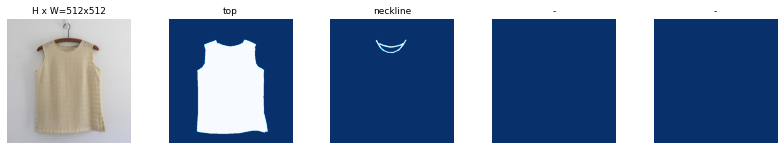

('/content/data/000b3a87508b0fa185fbd53ecbe2e4c6.jpg', ['dress', 'neckline', 'bag, wallet'])


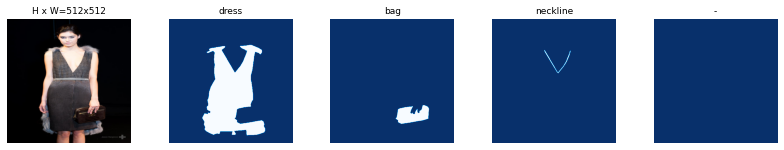

('/content/data/0010ef2da53cd76ee26122a65f6e76ee.jpg', ['shoe', 'shoe', 'skirt', 'shirt, blouse', 'neckline', 'glasses', 'bag, wallet'])


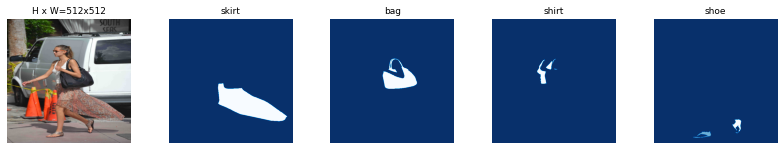

('/content/data/000b3a87508b0fa185fbd53ecbe2e4c6.jpg', ['dress', 'neckline', 'bag, wallet'])


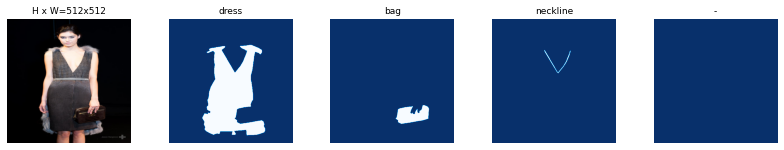

('/content/data/000b3ec2c6eaffb491a5abb72c2e3e26.jpg', ['shoe', 'shoe', 'pants', 'top, t-shirt, sweatshirt', 'pocket', 'sleeve', 'sleeve', 'neckline'])


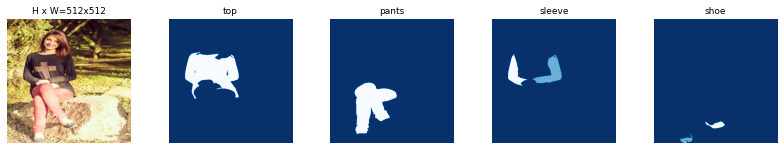

('/content/data/00048c3a2fb9c29340473c4cfc06424a.jpg', ['glasses', 'top, t-shirt, sweatshirt', 'neckline', 'skirt', 'zipper', 'bag, wallet', 'shoe', 'shoe'])


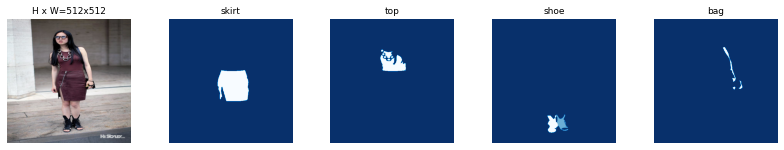

In [85]:
dataset = FashionDataset(image_df_try)
dataset.prepare()

for i in range(6):
    image_id = random.choice(dataset.image_ids)
    print(dataset.image_reference(image_id))
    
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=4)



*   belum eksplor tree kategori nya
*   belum eksplor quantity per class

